In [1]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

# load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
from scipy.stats import zscore
from umap import UMAP
from sklearn.mixture import GaussianMixture
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [42]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/eval{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '01_eval.py')

# Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [71]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_orig_add_data/config.yaml'

# load data

In [7]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [8]:
data_types = ['train', 'valid_source', 'valid_target']

In [9]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

In [10]:
# for train datasets
def get_target_names(wav_names):
    target_names = []
    for wav_name in wav_names:
        if 'target' in wav_name:
            target_names.append(wav_name)
    
    return target_names

# evaluation

## calc MVG (multivariate Gaussian)

In [11]:
com.tic()

MVG = {}
for machine_type in machine_types:
    MVG[machine_type] = {}
    ext_data = load_ext_data(machine_type)
    
    mean = ext_data['train']['features'].mean(axis=0)
    cov_estimator = LedoitWolf()
    cov_estimator.fit(ext_data['train']['features'])
    cov = cov_estimator.covariance_
    MVG[machine_type]['mean'] = mean
    MVG[machine_type]['cov'] = cov

com.toc()

elapsed time: 26.980991125 [sec]


## estimate

In [12]:
def calc_mahalanobis(mean, cov, samples):
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    dists = [mahalanobis(sample, mean, cov_inv) for sample in samples]
    # np.array
    dists = np.array(dists)
    return dists

In [40]:
from IPython.display import display

In [49]:
def get_score_perID(describe_df, max_fpr=0.1):
    # ユニークsectionを取得、昇順ソート
    sections = np.sort(describe_df['section_types'].unique())

    for section in sections:
        per_section_df = describe_df[describe_df['section_types'] == section]
        per_section_AUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'])
        per_section_pAUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'], max_fpr=max_fpr)
        # column = [AUC,pAUC], row = index
        score_df = pd.DataFrame(np.stack([per_section_AUC, per_section_pAUC]), index=['AUC', 'pAUC']).T
        # indexをsectionナンバーにrename
        # column = [AUC,pAUC], row = [section]
        score_df.index = [section]
        if section == 0:
            scores_df = score_df.copy()
        else:
            # 結合
            scores_df = scores_df.append(score_df)
    return scores_df

In [70]:
np.array(ext_data[phase]['wav_names'])

array(['/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/dev_data/valve/target_test/section_00_target_test_anomaly_0000.wav',
       '/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/dev_data/valve/target_test/section_00_target_test_anomaly_0001.wav',
       '/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/dev_data/valve/target_test/section_00_target_test_anomaly_0002.wav',
       '/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/dev_data/valve/target_test/section_00_target_test_anomaly_0003.wav',
       '/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/dev_data/valve/target_test/section_00_target_test_anomaly_0004.wav',
       '/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/dev_data/valve/target_test/section_00_target_test_anomaly_0005.wav',
       '/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/dev_data/valve/target_test/section_00_target_test_anomaly_0006.wav',
       '/media/hiroki/HDD1TB/research/dcase2021_task2/datasets/dev_data/valv

In [72]:
preds_pd = np.stack([np.array(ext_data[phase]['wav_names']), preds], axis=1)
preds_pd = pd.DataFrame(preds_pd, columns=['wav_name', 'pred'])

In [73]:
preds_pd

,wav_name,pred
0,/media/hiroki/HDD1TB/research/dcase2021_task2/...,39.084515
1,/media/hiroki/HDD1TB/research/dcase2021_task2/...,52.235477
2,/media/hiroki/HDD1TB/research/dcase2021_task2/...,57.377575
3,/media/hiroki/HDD1TB/research/dcase2021_task2/...,39.95069
4,/media/hiroki/HDD1TB/research/dcase2021_task2/...,87.083595
...,...,...
595,/media/hiroki/HDD1TB/research/dcase2021_task2/...,51.463936
596,/media/hiroki/HDD1TB/research/dcase2021_task2/...,60.254486
597,/media/hiroki/HDD1TB/research/dcase2021_task2/...,63.186653
598,/media/hiroki/HDD1TB/research/dcase2021_task2/...,34.048546


## Calc Score

In [74]:
for i, machine_type in enumerate(machine_types):
    logger.info('CALC SCORE')
    logger.info(machine_type)
    # get MVG
    tr_mean = MVG[machine_type]['mean']
    tr_cov = MVG[machine_type]['cov']
    # load samples
    ext_data = load_ext_data(machine_type)
    for phase in ['valid_source', 'valid_target']:
        # pred
        samples = ext_data[phase]['features']
        preds = calc_mahalanobis(tr_mean, tr_cov, samples)
        section_types = com.get_section_types(ext_data[phase]['wav_names'])
        # wavname + pred
        preds_pd = np.stack([np.array(ext_data[phase]['wav_names']), preds], axis=1)
        preds_pd = pd.DataFrame(preds_pd, columns=['wav_name', 'pred'])
        preds_pd.to_csv(OUT_PRED_DIR + f'/pred_{machine_type}_{phase}.csv')
        # dataframe作成
        describe_df = com.get_pred_discribe(labels=ext_data[phase]['labels'],
                                            preds=preds,
                                            section_types=section_types)
        # スコア算出(AUC, pAUC)
        scores_df = get_score_perID(describe_df, max_fpr=0.1)

        # 結合(source + target)
        if phase == 'valid_source':
            scores_df = scores_df.rename(index=lambda num: 'Source_' + f'{num}')
            all_scores_df = scores_df.copy()
        else:
            scores_df = scores_df.rename(index=lambda num: 'Target_' + f'{num}')
            all_scores_df = all_scores_df.append(scores_df)
            
    # 平均
    mean_df = pd.DataFrame(all_scores_df.mean(axis=0)).T
    mean_df.index = ['mean']
    # 調和平均
    hmean = scipy.stats.hmean(all_scores_df, axis=0)
    hmean_df = pd.DataFrame(hmean, index=['AUC', 'pAUC']).T
    hmean_df.index = ['h_mean']
    # 結合
    all_scores_df = all_scores_df.append(mean_df)
    all_scores_df = all_scores_df.append(hmean_df)
    # 出力
    all_scores_df.to_csv(f'{OUT_SCORE_DIR}/{machine_type}_score.csv')
    # display
    display(all_scores_df)

2021-04-12 21:25:06,288 - 01_eval.py - INFO - CALC SCORE
2021-04-12 21:25:06,290 - 01_eval.py - INFO - fan


,AUC,pAUC
Source_0,0.713500,0.594211
Source_1,0.495500,0.503684
Source_2,0.577000,0.505263
Target_0,0.741300,0.563158
Target_1,0.516200,0.497895
Target_2,0.569000,0.483684
mean,0.602083,0.524649
h_mean,0.588438,0.521782


2021-04-12 21:25:10,178 - 01_eval.py - INFO - CALC SCORE
2021-04-12 21:25:10,179 - 01_eval.py - INFO - gearbox


,AUC,pAUC
Source_0,0.660562,0.565067
Source_1,0.872857,0.663201
Source_2,0.639627,0.510905
Target_0,0.828221,0.648717
Target_1,0.840449,0.659952
Target_2,0.702222,0.555138
mean,0.757323,0.600497
h_mean,0.745876,0.594473


2021-04-12 21:25:14,111 - 01_eval.py - INFO - CALC SCORE
2021-04-12 21:25:14,112 - 01_eval.py - INFO - pump


,AUC,pAUC
Source_0,0.678300,0.657368
Source_1,0.610000,0.541053
Source_2,0.598900,0.526316
Target_0,0.610200,0.541579
Target_1,0.465000,0.483684
Target_2,0.532500,0.492632
mean,0.582483,0.540439
h_mean,0.574128,0.535079


2021-04-12 21:25:18,028 - 01_eval.py - INFO - CALC SCORE
2021-04-12 21:25:18,030 - 01_eval.py - INFO - slider


,AUC,pAUC
Source_0,0.672100,0.540000
Source_1,0.739000,0.603684
Source_2,0.660071,0.571723
Target_0,0.667400,0.555789
Target_1,0.604388,0.543287
Target_2,0.604191,0.512940
mean,0.657858,0.554571
h_mean,0.654731,0.553154


2021-04-12 21:25:21,638 - 01_eval.py - INFO - CALC SCORE
2021-04-12 21:25:21,639 - 01_eval.py - INFO - ToyCar


,AUC,pAUC
Source_0,0.619100,0.520000
Source_1,0.567000,0.505789
Source_2,0.778600,0.522105
Target_0,0.527900,0.532105
Target_1,0.614400,0.538947
Target_2,0.584900,0.499474
mean,0.615317,0.519737
h_mean,0.606375,0.519372


2021-04-12 21:25:25,339 - 01_eval.py - INFO - CALC SCORE
2021-04-12 21:25:25,340 - 01_eval.py - INFO - ToyTrain


,AUC,pAUC
Source_0,0.794100,0.656316
Source_1,0.658100,0.522632
Source_2,0.662000,0.484211
Target_0,0.702600,0.586316
Target_1,0.574300,0.496316
Target_2,0.724800,0.525789
mean,0.685983,0.545263
h_mean,0.679224,0.539346


2021-04-12 21:25:28,909 - 01_eval.py - INFO - CALC SCORE
2021-04-12 21:25:28,910 - 01_eval.py - INFO - valve


,AUC,pAUC
Source_0,0.550800,0.510000
Source_1,0.511900,0.496842
Source_2,0.634600,0.501053
Target_0,0.477000,0.490000
Target_1,0.655000,0.577368
Target_2,0.512400,0.484211
mean,0.556950,0.509912
h_mean,0.549471,0.508159


2021-04-12 21:10:44,030 - 01_eval.py - INFO - fan valid_source AUC : 0.5919777777777778
2021-04-12 21:10:44,032 - 01_eval.py - INFO - fan valid_target AUC : 0.6142888888888889


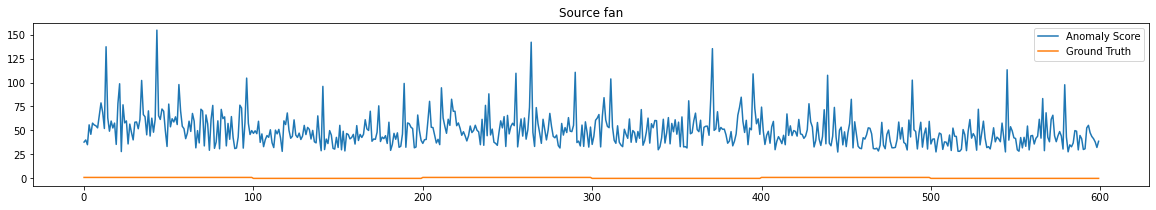

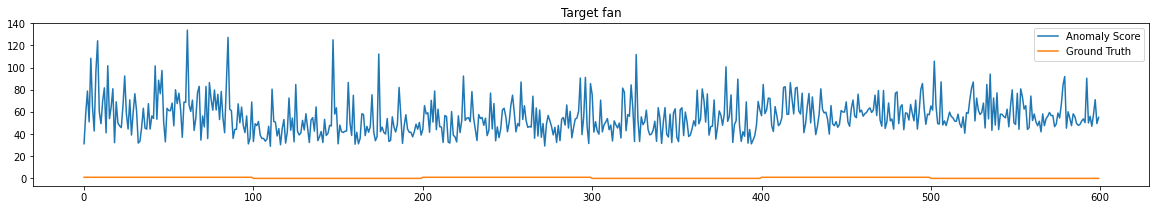

2021-04-12 21:10:47,948 - 01_eval.py - INFO - gearbox valid_source AUC : 0.7237507018528917
2021-04-12 21:10:47,954 - 01_eval.py - INFO - gearbox valid_target AUC : 0.7878525196486362


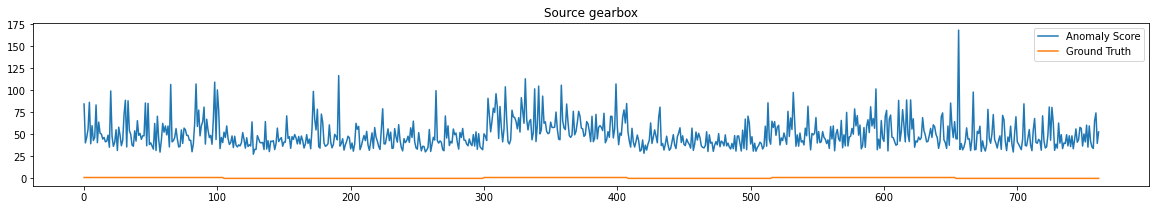

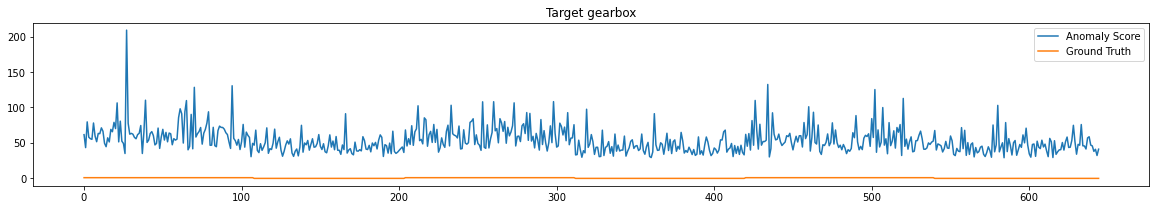

2021-04-12 21:10:51,437 - 01_eval.py - INFO - pump valid_source AUC : 0.6335888888888889
2021-04-12 21:10:51,441 - 01_eval.py - INFO - pump valid_target AUC : 0.5335222222222222


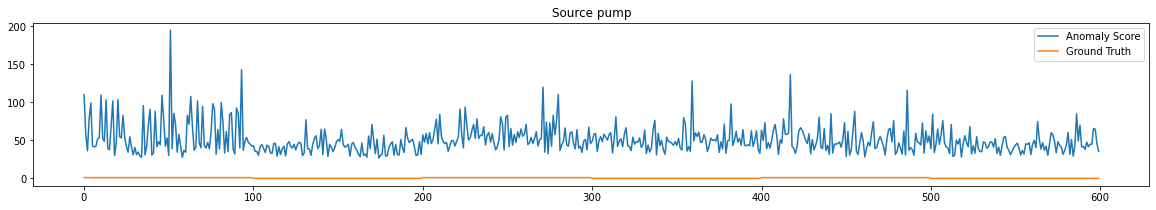

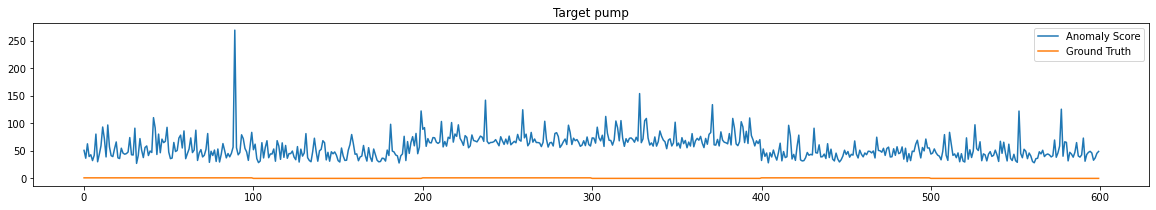

2021-04-12 21:10:54,859 - 01_eval.py - INFO - slider valid_source AUC : 0.6852702414014099
2021-04-12 21:10:54,861 - 01_eval.py - INFO - slider valid_target AUC : 0.6275551876379691


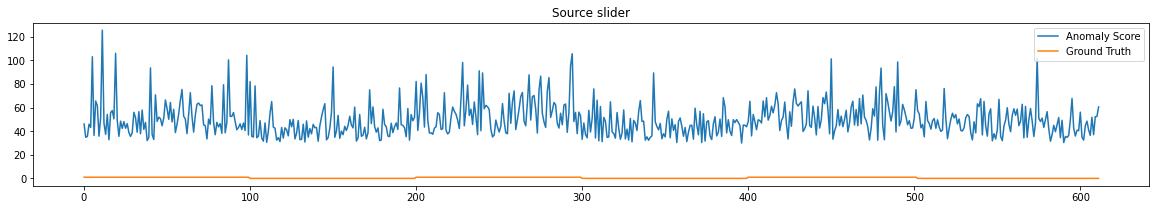

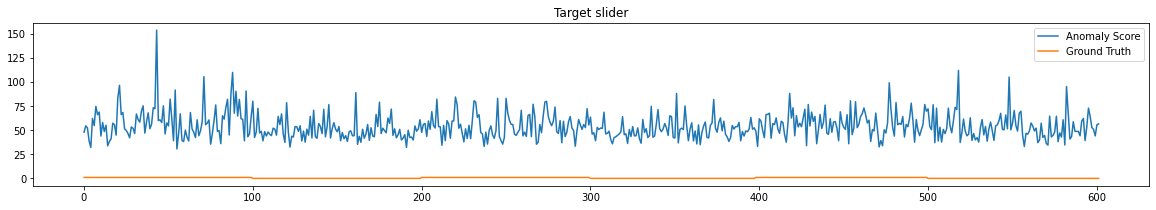

2021-04-12 21:10:58,264 - 01_eval.py - INFO - ToyCar valid_source AUC : 0.6548333333333334
2021-04-12 21:10:58,266 - 01_eval.py - INFO - ToyCar valid_target AUC : 0.5472111111111111


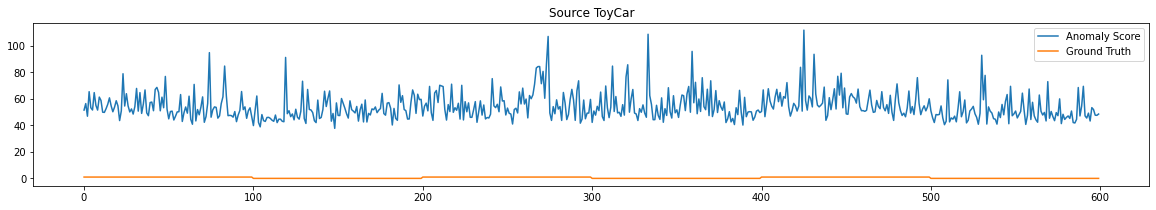

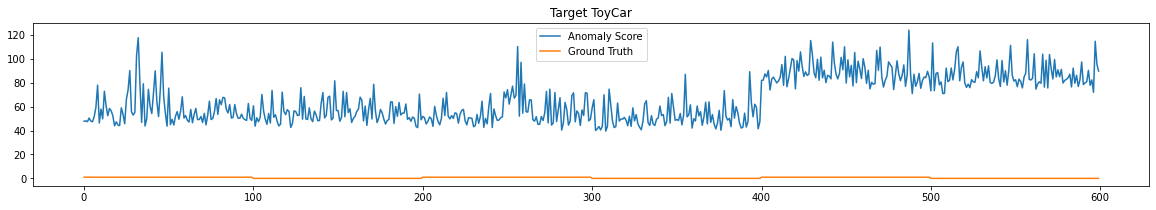

2021-04-12 21:11:01,327 - 01_eval.py - INFO - ToyTrain valid_source AUC : 0.6555888888888889
2021-04-12 21:11:01,329 - 01_eval.py - INFO - ToyTrain valid_target AUC : 0.6009


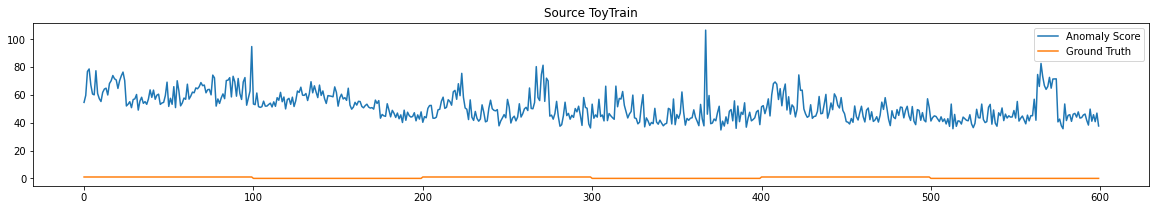

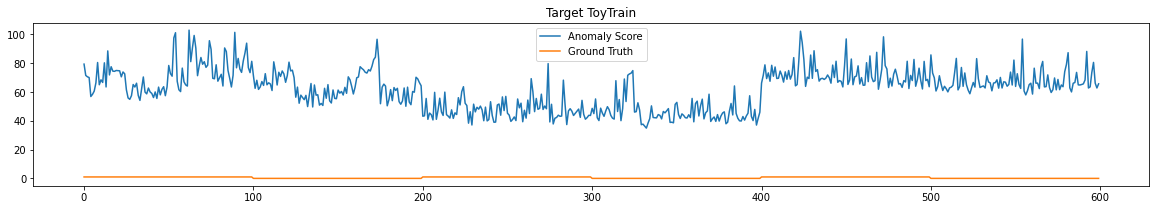

2021-04-12 21:11:04,783 - 01_eval.py - INFO - valve valid_source AUC : 0.5646777777777777
2021-04-12 21:11:04,785 - 01_eval.py - INFO - valve valid_target AUC : 0.5398666666666667


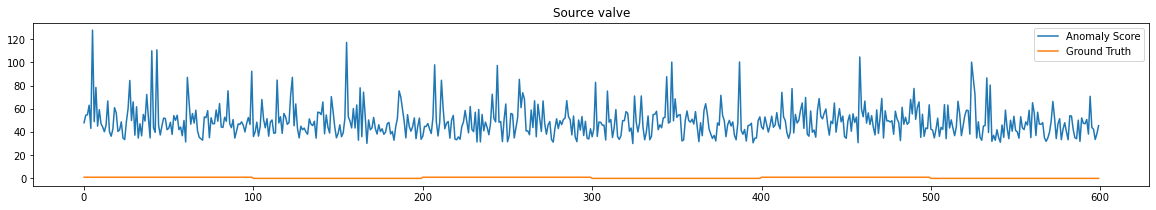

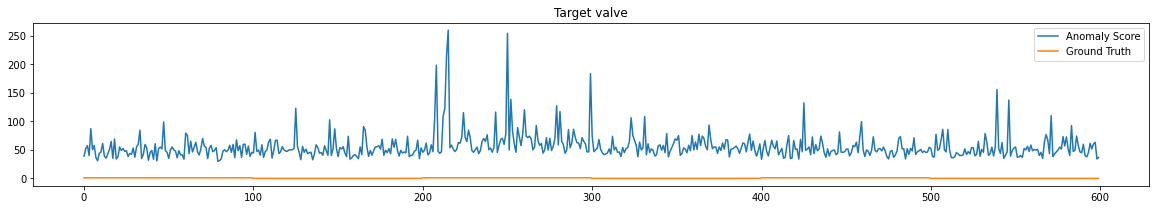

In [68]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

## calc GMM

In [ ]:
machine_types

In [12]:
ext_data = load_ext_data(machine_types[6])
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(ext_data['train']['features'])

GaussianMixture(n_components=3, random_state=42)

In [16]:
gmm.bic(ext_data['train']['features'])

3319258.8933906704

In [22]:
pred = gmm.predict(ext_data['train']['features'])

(array([ 790.,    0.,    0.,    0.,    0.,  378.,    0.,    0.,    0.,
        1841.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

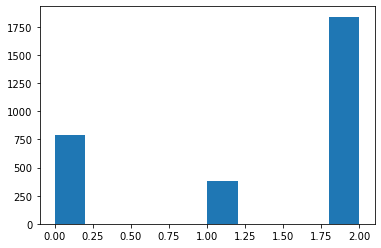

In [27]:
plt.hist(pred)

In [ ]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_

In [75]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_


# calc mahalanobis (Anomaly Score)
valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]

In [ ]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = MVG[machine_type]['cov']
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')

In [71]:
gmm_section_types = gmm.predict(feats)

/home/hiroki/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

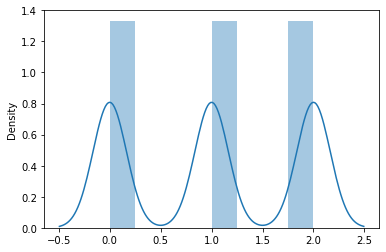

In [75]:
sns.distplot(section_types)

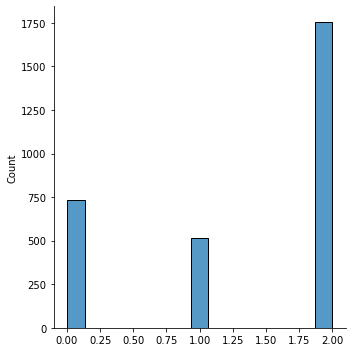

In [74]:
sns.displot(gmm_section_types)